In [101]:
import numpy as np
import pandas as pd
import sys
import os
import math
import scipy

BASE = os.path.realpath('../')
sys.path.insert(0, os.path.join(BASE, 'src'))

import dual_crispr_screen
import imp
imp.reload(dual_crispr_screen)

import matplotlib.pyplot as plt 

%load_ext autoreload

%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Global parameters

BASE = os.path.realpath('../')
TEST_SET = os.path.join(BASE, 'data', 'test_data','input_data', 'TestSet8')
A549 = os.path.join(BASE, 'data', 'test_data', 'input_data', 'A549')

counts_file = os.path.join(A549, 'A549_timepoint_counts.txt')

# Read in counts
A549_full_counts = pd.read_csv(counts_file, sep='\t')

In [119]:
def run_screen(counts_df, times=[3,14,21,28], niter=2): 
    times = np.array(times)
    screen = dual_crispr_screen.Screen(counts_df, times)

    # set some parameters
    # number of iterations to perform
    screen.options.niter = niter
    screen.options.null_target_id = '0'
    screen.options.verbose = False

    # perform construct fitness calculation
    screen.run_construct_fitting()

    # run bootstraps
    screen.run_bootstrap()

    # summarize results 
    screen.summarize()
    
    return screen.results, screen.fc, screen.allbad


In [167]:
def main(counts, fitness, allbad, threshold=0.5, n=100):
    df = remove_nontargeting(counts)
    low_df, high_df = select_subset(df, 'testing_T3_1', threshold=threshold)
    
    return get_fitness(low_df, fitness, allbad, n=n), get_fitness(high_df, fitness, allbad, n=n)
    

def remove_nontargeting(df, col1='probe_a_id', col2='probe_b_id', exclude='NonTargeting'): 
    tmp = df.loc[~(df[col1].str.contains(exclude)) & \
                  ~(df[col2].str.contains(exclude))]
    
    tmp.index = np.arange(0, tmp.shape[0])
    
    return tmp

def select_random_subset(df, fraction=0.05): 
    '''randomly selects fraction*df.shape[0] number of rows'''
    
    select = math.floor(fraction*df.shape[0])
    subset = np.random.choice(df.shape[0], size=select)
    
    return df.iloc[subset, :]

def select_subset(df, column, threshold=0.5, ): 
    avg = np.mean(df[column])
    std = np.std(df[column])
    
    high_df = df.loc[(df[column] > avg + threshold*std)]
    low_df = df.loc[(df[column] < avg - threshold*std)]
    
    return low_df, high_df

def get_fitness(df, fitness, allbad, n=100, col1='probe_a_id', col2='probe_b_id'): 
    names = df[[col1, col2]]
    
    #fc = [fitness.at[row[col1], row[col2]] for _, row in names.iterrows()]
    
    
    fc = []
    bad = []
    for _, row in names.iterrows(): 
        fc.append(fitness.at[row[col1], row[col2]])
        bad.append(allbad.at[row[col1], row[col2]])
        
    df['fc'] = fc
    df['allbad'] = bad
    
    df = df.loc[df['allbad'] != 1]
    
    return df.loc[np.random.choice(np.asarray(df.index), size=n), 'fc'].values
    

In [122]:
%time control, fitness, allbad = run_screen(A549_full_counts, niter=2)

/cellar/users/samsonfong/crappy/src/fit_ac_fc.py:261: RuntimeWarning: invalid value encountered in true_divide
  fc = np.divide(f.sum(axis=0), var_time.sum(axis=0))
/cellar/users/samsonfong/crappy/src/fit_ac_fc.py:287: RuntimeWarning: invalid value encountered in true_divide
  sdfc = np.divide(num, denom).data


CPU times: user 1min 48s, sys: 3.96 s, total: 1min 52s
Wall time: 6.52 s


/cellar/users/samsonfong/crappy/src/bootstrap_pi.py:274: RuntimeWarning: invalid value encountered in true_divide
  fdr_right = np.minimum(1, enull(-pi_mean)/(1-emean(pi_mean)))


/cellar/users/samsonfong/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/samsonfong/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.112071079815


Text(0.5,1,'Range: +/- (0.5, 1) std\np-value: 0.112071079815')

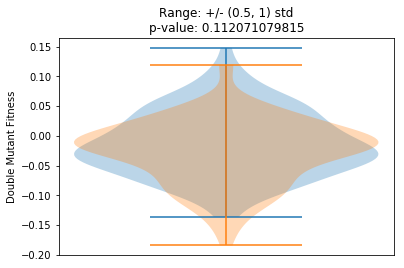

In [169]:
a, b = main(A549_full_counts, tmp, allbad)
print(scipy.stats.mannwhitneyu(a,b).pvalue)
fig, ax = plt.subplots()

ax.violinplot(a)
ax.violinplot(b)

ax.set_ylabel('Double Mutant Fitness')
ax.set_xticks([])
ax.set_title('Range: +/- (0.5, 1) std\np-value: %s' % scipy.stats.mannwhitneyu(a,b).pvalue)

In [118]:
scipy.stats.ttest_ind(np.arange(0, 10), np.arange(100, 110))

Ttest_indResult(statistic=-73.854894587599645, pvalue=8.3688725707031461e-24)

8.17910128031e-59


Text(0.5,1,'Range: +/- (0.5, 1.5) std\np-value: 8.17910128031e-59')

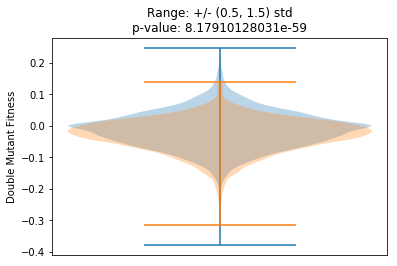

In [116]:
a, b = main(A549_full_counts, tmp, high=1.5)
print(scipy.stats.mannwhitneyu(a,b).pvalue)
fig, ax = plt.subplots()

ax.violinplot(a)
ax.violinplot(b)

ax.set_ylabel('Double Mutant Fitness')
ax.set_xticks([])
ax.set_title('Range: +/- (0.5, 1.5) std\np-value: %s' % scipy.stats.mannwhitneyu(a,b).pvalue)

In [57]:
low, high = select_subset(A549_full_counts, 'testing_T3_1')

In [58]:
low

,construct_id,probe_a_id,probe_b_id,target_a_id,target_b_id,testing_T3_1,testing_T3_2,testing_T14_1,testing_T14_2,testing_T21_1,testing_T21_2,testing_T28_1,testing_T28_2
0,BRCA1_chr17_41276018__NonTargetingControlGuide...,BRCA1_chr17_41276018,NonTargetingControlGuideForHuman0412,BRCA1,NonTargetingControlGuideForHuman0412,133.0,168.0,1.0,46.0,0.0,48.0,0.0,1.0
7,NonTargetingControlGuideForHuman0362__CDKN2A_c...,CDKN2A_chr9_21968726,NonTargetingControlGuideForHuman0362,CDKN2A,NonTargetingControlGuideForHuman0362,213.0,301.0,385.0,245.0,199.0,376.0,268.0,315.0
8,HDAC1_chr1_32757816__NonTargetingControlGuideF...,HDAC1_chr1_32757816,NonTargetingControlGuideForHuman0412,HDAC1,NonTargetingControlGuideForHuman0412,129.0,201.0,88.0,139.0,130.0,40.0,168.0,134.0
9,SMO_chr7_128845117__NonTargetingControlGuideFo...,NonTargetingControlGuideForHuman0362,SMO_chr7_128845117,NonTargetingControlGuideForHuman0362,SMO,164.0,156.0,319.0,404.0,75.0,125.0,110.0,196.0
11,JAK2_chr9_5050721__NonTargetingControlGuideFor...,JAK2_chr9_5050721,NonTargetingControlGuideForHuman0412,JAK2,NonTargetingControlGuideForHuman0412,185.0,281.0,61.0,191.0,18.0,210.0,0.0,221.0
22,NonTargetingControlGuideForHuman0412__SETD2_ch...,NonTargetingControlGuideForHuman0412,SETD2_chr3_47142951,NonTargetingControlGuideForHuman0412,SETD2,192.0,119.0,181.0,555.0,319.0,217.0,520.0,180.0
30,NonTargetingControlGuideForHuman0352__CHEK2_ch...,CHEK2_chr22_29090029,NonTargetingControlGuideForHuman0352,CHEK2,NonTargetingControlGuideForHuman0352,123.0,118.0,284.0,526.0,415.0,957.0,265.0,2670.0
33,BRAF_chr7_140534469__NonTargetingControlGuideF...,BRAF_chr7_140534469,NonTargetingControlGuideForHuman0412,BRAF,NonTargetingControlGuideForHuman0412,181.0,423.0,1034.0,688.0,842.0,686.0,1293.0,1616.0
35,NonTargetingControlGuideForHuman0352__IGF1R_ch...,IGF1R_chr15_99434807,NonTargetingControlGuideForHuman0352,IGF1R,NonTargetingControlGuideForHuman0352,182.0,352.0,594.0,603.0,800.0,256.0,1679.0,632.0
37,HDAC1_chr1_32792637__NonTargetingControlGuideF...,HDAC1_chr1_32792637,NonTargetingControlGuideForHuman0412,HDAC1,NonTargetingControlGuideForHuman0412,145.0,178.0,272.0,458.0,674.0,325.0,522.0,384.0


(array([  6.33000000e+02,   5.78000000e+02,   7.90000000e+02,
          9.18000000e+02,   1.11400000e+03,   1.22800000e+03,
          1.25000000e+03,   1.25500000e+03,   1.32900000e+03,
          1.28500000e+03,   1.24300000e+03,   1.12700000e+03,
          1.18500000e+03,   1.11200000e+03,   9.65000000e+02,
          8.95000000e+02,   8.69000000e+02,   7.83000000e+02,
          7.40000000e+02,   6.52000000e+02,   5.89000000e+02,
          5.23000000e+02,   4.51000000e+02,   3.99000000e+02,
          3.62000000e+02,   3.59000000e+02,   3.04000000e+02,
          2.33000000e+02,   2.30000000e+02,   1.93000000e+02,
          1.79000000e+02,   1.51000000e+02,   1.40000000e+02,
          9.80000000e+01,   1.15000000e+02,   9.40000000e+01,
          7.40000000e+01,   5.70000000e+01,   5.90000000e+01,
          4.60000000e+01,   4.80000000e+01,   3.50000000e+01,
          3.70000000e+01,   2.10000000e+01,   1.90000000e+01,
          1.10000000e+01,   1.70000000e+01,   1.30000000e+01,
        

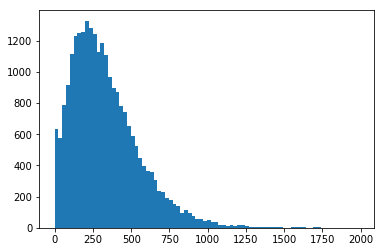

In [45]:
plt.hist(A549_full_counts['testing_T3_1'], bins=80)